# liquidSVM for Python

We give a demonstration of the capabilities of liquidSVM from a Python viewpoint.
More information can be found in the help (e.g. `?mcSVM`).

> *Disclaimer:* liquidSVM and the Python-bindings are in general quite stable and well tested by several people.
> However, use in production is at your own risk.
> 
> If you run into problems please check first the documentation for more details,
> or report the bug to the maintainer.

## Table of Contents:
* [Installation](#Installation)
* [liquidSVM in one Minute](#liquidSVM-in-one-Minute)
    * [LS-Regression](#LS-Regression)
    * [Multi-class](#Multi-class)
    * [Cells](#Cells)
    * [Saving and loading Solutions](#Saving-and-loading-Solutions)
* [Learning Scenarios](#Learning-Scenarios)
    * [Multiclass classification](#Multiclass-classification)
    * [Quantile regression](#Quantile-regression)
    * [Expectile regression](#Expectile-regression)
    * [Neyman-Pearson-Learning](#Neyman-Pearson-Learning)
    * [ROC curve](#ROC-curve)
* [LiquidData](#LiquidData)


## Installation

  * Install it using any of the following variants:
    ```
easy_install --user --upgrade liquidSVM
pip install --user --upgrade liquidSVM
```
  * If you want to compile liquidSVM for your machine download <http://www.isa.uni-stuttgart.de/software/python/liquidSVM-python.tar.gz>.
    For Windows there are binaries at [liquidSVM-python.win-amd64.zip](http://www.isa.uni-stuttgart.de/software/python/liquidSVM-python.win-amd64.zip),
    for Mac at [liquidSVM-python.macosx.tar.gz](http://www.isa.uni-stuttgart.de/software/python/liquidSVM-python.macosx.tar.gz)
More information on the installation is in the [README](http://www.isa.uni-stuttgart.de/software/python/README.html).

## liquidSVM in one Minute

In [1]:
from liquidSVM import *

Some stuff we need for this notebook

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### LS-Regression

In [3]:
# Load test and training data
reg = LiquidData('reg-1d')

Now `reg.train` contains the training data and `reg.test` the testing data.
Both have the labels in its `.target` and the feature is in `.data`.
To train on the data and select the best hyperparameters do
(`display=1` gives some information as the training progresses, but only on the command line, not in this jupyter notebook.)

In [4]:
model = lsSVM(reg.train,display=1)

Now you can test with any test set:

In [5]:
result, err = model.test(reg.test)
err[0,0]

0.0053492823176539582

We also can plot the regression:

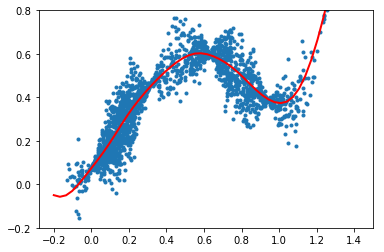

In [6]:
plt.plot(reg.test.data, reg.test.target, '.')
x = np.linspace(-.2,1.4)
y = model.predict(x)
plt.plot(x, y, 'r-', linewidth=2)
plt.ylim(-.2,.8);

As a convenience, since `reg` already contains `.train` and `.test`
you can do the whole experiment in one line.
Then the result is stored in `model.lastResult`:

In [7]:
model = lsSVM(reg, display=1)
result, err = model.lastResult
err[0,0]

0.0053492823176539582

### Multi-class

In [8]:
banana = LiquidData('banana-mc')

The following performs multi-class classification

In [9]:
model = mcSVM(banana.train)

(2, 4000)
(44,) (44, 44) (1936, 2)


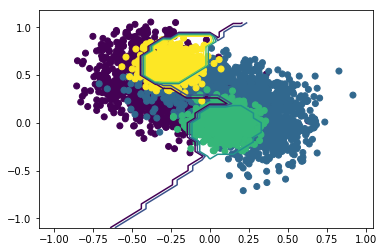

In [10]:
print(banana.train.data.T.shape)
plt.scatter(banana.train.data[:,0],banana.train.data[:,1], c=banana.train.target)

x = np.arange(-1.1,1.1,.05)
X,Y = np.meshgrid(x, x)
z = np.array(np.meshgrid(x,x)).reshape(2,-1).T
print(x.shape,X.shape, z.shape)
Z = model.predict(z).reshape(len(x),len(x))
#contour(x,x,z, add=T, levels=1:4,col=1,lwd=4)
CS = plt.contour(X, Y, Z, 4, linewidth=4)

In this case `err[:,0]` shows both the global miss-classification error as well the errors
of the underlying binary tasks, for more details see [Multiclass classification]:

In [11]:
result,err = model.test(banana.test)
err[:,0]

array([ 0.22125 ,  0.1425  ,  0.111   ,  0.0965  ,  0.075   ,  0.0785  ,
        0.000625])

### Cells

If data gets too big for the memory on your machine:

In [38]:
covtype = LiquidData('covtype.5000')
model = mcSVM(covtype, display=1, useCells=True)
result, err = model.lastResult
err[0,0]

0.19506028782574875

A major issue with SVMs is that for larger sample sizes the kernel matrix
does not fit into the memory any more.
Classically this gives an upper limit for the class of problems that traditional
SVMs can handle without significant runtime increase.
The concept of cells makes it possible to circumvent these issues.

If you specify `useCells=True` then the sample space $X$ gets partitioned into
a number of cells.
The training is done first for cell 1 then for cell 2 and so on.
Now, to predict the label for a value $x\in X$ liquidSVM first finds out
to which cell this $x$ belongs and then uses the SVM of that cell to predict
a label for it.

We first consider a medium size sample of the `covtype` data set.
`LiquidData` will download this from http://www.isa.uni-stuttgart.de/LiquidData/:

In [44]:
co = LiquidData('covtype.10000')
%time mcSVM(co.train);

CPU times: user 3min, sys: 460 ms, total: 3min 1s
Wall time: 1min 31s


In [45]:
%time mcSVM(co.train, useCells=True);

CPU times: user 26.4 s, sys: 140 ms, total: 26.5 s
Wall time: 14.6 s


This is about 5 times faster! (The user time is about three times the elapsed time since we are using 2 threads.)

By using the partitioning facility of liquidSVM you can even bigger problems:

In [46]:
co = LiquidData('covtype.50000')
%time mcSVM(co.train,useCells=True);

CPU times: user 2min 9s, sys: 768 ms, total: 2min 10s
Wall time: 1min 12s


Note that with this data set `useCells=F` here only works if your system has enough free memory (~26GB).

Even the full `covtype` data set with over 460'000 rows
(about 110'000 samples retained for testing) is now treatable in under 9 minutes from within python:

In [51]:
co = LiquidData('covtype-full')
%time mcSVM(co.train,useCells=True);

CPU times: user 16min 2s, sys: 6.24 s, total: 16min 8s
Wall time: 9min 2s


> If you run into memory issues turn cells on: `useCells=True`.
> If you have less than 10GB of RAM use `store_solutions_internally=False` for the latter.

## Learning Scenarios

liquidSVM organizes its work into tasks:
E.g. in multiclass classification the problem has to be reduced into
several binary classification problems. Or in Quantile regression,
the SVM is learned simultaneously for different weights and
then the selection of hyperparameters produces different tasks.

Behind the scenes `svm(formula, data, ...)` does the following:
```python
model = SVM(data)
model.train(...)
model.select(...)
```

The following learning scenarios hide these in higher level functions.

### Multiclass classification

Multiclass classification has to be reduced to binary classification
There are two strategies for this:

* all-vs-all: for every pairing of classes a binary SVM is trained
* one-vs-all: for every class a binary SVM is trained with that class as one label and all other classes
are clumped together to another label

Then for any point in the test set, the winning label is chosen.
A second choice to make is whether the hinge or the least-squares loss should be used
for the binary classification problems.

Let us look at the example dataset `banana-mc` which has 4 labels.

Since there are 6 pairings, `AvA` trains 6 tasks, whereas
`OvA` trains 4 tasks:

In [5]:
banana = LiquidData('banana-mc')

for mcType in ["AvA_hinge", "OvA_hinge", "AvA_ls", "OvA_hinge"]:
    print("\n======", mcType, "======")
    model = mcSVM(banana.train, mcType=mcType)
    result, err = model.test(banana.test)
    
    print("global err:", err[0,0])
    print("task errs:", err[1:,0])
    
    print(result[:3,])


====== AvA_hinge ======
global err: 0.22125
task errs: [ 0.1425    0.111     0.0965    0.075     0.0785    0.000625]
[[ 1.  1.  1.  1.  2.  4.  4.]
 [ 4.  1.  1.  4.  2.  4.  4.]
 [ 4.  1.  1.  4.  2.  4.  4.]]

====== OvA_hinge ======
global err: 0.22075
task errs: [ 0.15275  0.12725  0.07925  0.0735 ]
[[ 1.          0.9890605  -0.80926743 -0.93348602 -0.95799295]
 [ 4.         -0.82750685 -0.90127207 -1.          0.75473953]
 [ 4.          0.03506588 -0.87285662 -0.99969308  0.17163619]]

====== AvA_ls ======
global err: 0.218
task errs: [ 0.14041667  0.11        0.0945      0.0765      0.0745      0.000625  ]
[[ 1.         -0.98695361 -0.97885371 -0.93789303 -0.24780736  0.85865243
   0.98131701]
 [ 4.         -0.76039797 -0.97954803  0.08532182 -0.8738455   1.          1.        ]
 [ 1.         -0.99814249 -0.983494   -0.16957639 -0.77514952  0.95740691
   1.        ]]

====== OvA_hinge ======
global err: 0.22075
task errs: [ 0.15275  0.12725  0.07925  0.0735 ]
[[ 1.          0.98

The first element in the errors gives the overall test error.
The other errors correspond to the tasks.
Also the result displays in the first column the final decision for
a test sample, and in the other columns the results of the binary classifications.
One can see nicely how the final prediction vote for any sample
is based on the 4 or 6 binary tasks.


> **NOTE** `AvA` is usually faster, since every binary SVM just trains
> on the data belonging to only two labels.
> On the other hand `OvA_ls` can give better results at the cost of longer training time.
> 
> OvA_hinge should not be used as it is not universally consistent.

### Probability estimation

If labels have values -1 or 1, then using the least-squares will estimate the conditional expectation.
Hence, this can be used to estimate probabilities:

In [15]:
banana_bc = LiquidData('banana-bc')
m = mcSVM(banana_bc.train, mcType="OvA_ls",display=1)

[[ 0.002946  ]
 [ 0.00267803]
 [ 0.01234504]
 [ 0.00212063]
 [ 0.        ]]


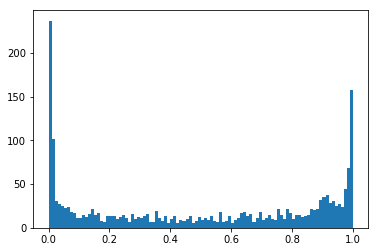

In [23]:
result, err = m.test(banana_bc.test)
probs = (result+1) / 2.0
print(probs[:5,:])
plt.hist(probs, 100);

And for multi-class classification it is similar:

In [29]:
banana = LiquidData('banana-mc')
m = mcSVM(banana.train, mcType="OvA_ls",display=1)

In [39]:
result, err = m.test(banana.test)
probs = (result[:,1:]+1) / 2.0
print(result.shape, probs.shape)
print(np.hstack((result,probs))[:5,:].round(2))

(4000, 5) (4000, 4)
[[ 1.    0.98 -0.97 -0.98 -1.    0.99  0.02  0.01  0.  ]
 [ 4.   -0.47 -1.   -1.    0.51  0.27  0.    0.    0.76]
 [ 1.    0.04 -0.98 -1.   -0.03  0.52  0.01  0.    0.48]
 [ 4.   -0.46 -0.98 -0.99  0.43  0.27  0.01  0.01  0.71]
 [ 4.   -0.69 -0.98 -0.99  0.64  0.16  0.01  0.01  0.82]]


### Quantile regression

This uses the quantile solver with pinball loss and performs selection for every quantile provided.

In [3]:
reg = LiquidData('reg-1d')
quantiles_list = [ 0.05, 0.1, 0.5, 0.9, 0.95 ]

model = qtSVM(reg.train, weights=quantiles_list)

result, err = model.test(reg.test)
err[:,0]

array([ 0.00706302,  0.011864  ,  0.02697517,  0.01243651,  0.00736297])

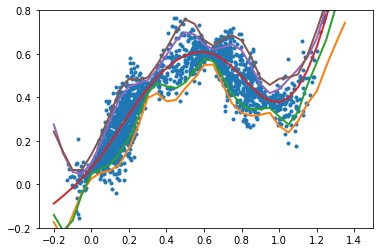

In [11]:
plt.plot(reg.test.data,reg.test.target,'.')
plt.ylim(-.2,.8)
x = np.arange(-0.2,1.4,0.05).reshape((-1,1))
lines = model.predict(x)
for i in range(len(quantiles_list)):
    plt.plot(x, lines[:,i], '-', linewidth=2)

In this plot you see estimations for two lower and upper quantiles as well as the median
of the distribution of the label $y$ given $x$.

### Expectile regression

This uses the expectile solver with weighted least squares loss and performs selection for every weight.
The 0.5-expectile in fact is just the ordinary least squares regression and hence estimates
the mean of $y$ given $x$.
And in the same way as quantiles generalize the median, expectiles generalize the mean.

In [3]:
reg = LiquidData('reg-1d')
expectiles_list = [ .05, 0.1, 0.5, 0.9, 0.95 ]

model = exSVM(reg.train, weights=expectiles_list)

result, err = model.test(reg.test)
err[:,0]

array([ 0.00103357,  0.00159214,  0.00270024,  0.0015866 ,  0.00139341])

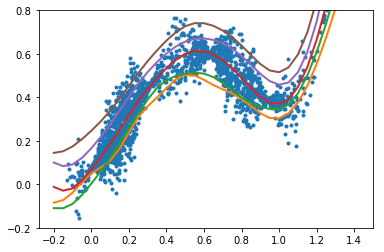

In [4]:
plt.plot(reg.test.data,reg.test.target,'.')
plt.ylim(-.2,.8)
x = np.arange(-0.2,1.4,0.05).reshape((-1,1))
lines = model.predict(x)
for i in range(len(expectiles_list)):
    plt.plot(x, lines[:,i], '-', linewidth=2)

### Neyman-Pearson-Learning

Neyman-Pearson-Learning attempts classification under the constraint
that the probability of false positives (Type-I error) is bound by a significance
level alpha, which is called here the NPL-constraint. 

In [35]:
banana = LiquidData('banana-bc')
constraint = 0.08
constraintFactors = np.array([1/2,2/3,1,3/2,2])

# class=-1 specifies the normal class
model = nplSVM(banana.train, nplClass=-1, constraintFactors=constraintFactors, constraint=constraint)

result, err = model.test(banana.test)

In [37]:
false_alarm_rate = (result[banana.test.target==-1,]==1).mean(0)
detection_rate = (result[banana.test.target==1,]==1).mean(0)

np.vstack( (constraint * constraintFactors,false_alarm_rate,detection_rate) ).round(3)

array([[ 0.04 ,  0.053,  0.08 ,  0.12 ,  0.16 ],
       [ 0.048,  0.055,  0.055,  0.126,  0.182],
       [ 0.639,  0.688,  0.7  ,  0.832,  0.878]])

You can see that the false alarm rate in the test set meet the
NPL-constraints quite nicely, and on the other hand
the the detection rate is increasing.

### ROC curve

Receiver Operating Characteristic curve (ROC curve) plots trade-off between
the false alarm rate and the detection rate 
for different weights (default is 9 weights).

In [6]:
banana = LiquidData('banana-bc')

model = rocSVM(banana.train,display=1)
result, err = model.test(banana.test)

[[ 0.035  0.054  0.066  0.07   0.076  0.073  0.067  0.054  0.038]
 [ 0.592  0.379  0.265  0.186  0.131  0.092  0.068  0.047  0.036]
 [ 0.011  0.04   0.074  0.11   0.173  0.226  0.286  0.349  0.439]]
FPR: [ 0.011  0.04   0.074  0.11   0.173  0.226  0.286  0.349  0.439]
1-DR: [ 0.592  0.379  0.265  0.186  0.131  0.092  0.068  0.047  0.036]


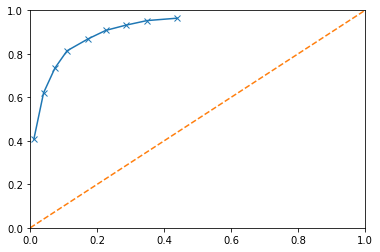

In [24]:
false_positive_rate = (result[banana.test.target==-1,:]==1).mean(0)
detection_rate = (result[banana.test.target==1,]==1).mean(0)

print(err.T.round(3))
print("1-DR:", 1-detection_rate)
print("FPR:",false_positive_rate)

plt.plot(false_positive_rate, detection_rate, 'x-')
plt.xlim(0,1); plt.ylim(0,1)
plt.plot([0,1],[0,1], '--');

This shows nice learning, since the ROC curve is near the north-west corner.

## LiquidData

As a convenience we provide several datasets prepared for training and testing.

> http://www.isa.uni-stuttgart.de/LiquidData

They can be imported by name e.g. using:

In [10]:
LiquidData('reg-1d');

This loads both `reg-1d.train.csv` as well as `reg-1d.test.csv` into
`reg.train` and `reg.test` respectively.

LiquidData sets have a strict format, they are comma-separated values and no header.
The first column is the target.
The other columns are the features and are put in to `.data`.

Before getting these data sets from our website, `LiquidData` first tries some directories in the filesystem:

1. the working directory `getwd()`
2. in your home directory `"~/LiquidData"`.
   In Windows, `~` typically is `C:\Users\username\Documents`
3. from the package itself
4. the webpage `http://www.isa.uni-stuttgart.de/LiquidData`

The data sets can be gzip-ped, which is recognized by the additional extension `.gz`, e.g.
`reg-1d.train.csv.gz` and `reg-1d.test.csv.gz`